### Multi step model (simple encoder-decoder)

In this notebook, we demonstrate how to:
- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time *t+1* to *t+3*) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder. 
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [10]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from IPython.display import Image
%matplotlib inline

from common.utils import load_data, mape, TimeSeriesTensor, create_evaluation_df

pd.options.display.float_format = '{:,.20f}'.format
np.set_printoptions(precision=20)
warnings.filterwarnings("ignore")

In [41]:
Paras = {
     'M0':['M0'],
    'e':['OMEGA','i0','omega','I_dot','Cus','Crs','e' , 'M0'],
    'sqrt_A':['Cuc','Crc','Del_n','Crs','sqrt_A','OMEGA_dot','Cus'],
    'OMEGA':['OMEGA','e','i0','omega'],
    'i0':['e','i0','omega','OMEGA' ,'I_dot'],
    'omega':['omega','e','OMEGA','i0'],
    'I_dot':['I_dot','e','Crs','Cuc'],
    'Cic':['M0','Cic'],
    'Cis':['Cis'],
    'OMEGA_dot':['OMEGA_dot','sqrt_A','Crc','Del_n','Cus' , 'omega' ],
    'Cuc':['Cuc','e','sqrt_A','I_dot','Crs'],
    'Cus':['Cus','sqrt_A','OMEGA_dot','Crc','Del_n','Cus'],
    'Crc':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Crs':['Crs'],
    'Del_n':['Crc','sqrt_A','OMEGA_dot','Cus','Del_n'],
    'Codes' : ['Codes']    
}

In [42]:
sat_var  = 2
var_name = 'Crs'

In [43]:
df = pd.read_csv("hourinterpol_21.csv" , parse_dates = True)
a = pd.to_datetime(df['Epoch_Time_of_Clock'])
print(type(a[0]))
#df = df.drop(['Unnamed: 0', 'Unnamed: 0.1' ,'sqrt_A'  ,'PRN','SV_Clock_Bias', 'SV_Clock_Drift', 'SV_Clock_Drift_Rate', 'IODE', 'Crs',
#       'Del_n', 'Cuc','Cus','Toe', 'Cic', 
#       'Cis', 'Crc', 'M0', 'OMEGA_dot', 'I_dot', 'Codes', 'GPS_week',
#       'L2_P_Data_flag', 'SV_accuracy', 'SV_health', 'Tgd', 'IODC', 'T_Tx',
#       'Fit_Interval' ,'Epoch_Time_of_Clock' ],axis =1 )
df = df.loc[:,Paras[var_name]]
#df.head()
#df = df.set_index(['Epoch_Time_of_Clock'])
df = df.set_index(a)
df.head()

<class 'pandas._libs.tslib.Timestamp'>


,Crs
Epoch_Time_of_Clock,
2017-11-02 00:00:00,36.35361028460000198947
2017-11-02 01:00:00,34.63119122119999815368
2017-11-02 02:00:00,32.61727921500000348942
2017-11-02 03:00:00,30.34622309439999909841
2017-11-02 04:00:00,27.90236791449999742554


In [44]:
test = df.iloc[265:408,:]

In [45]:

df.head(7)

,Crs
Epoch_Time_of_Clock,
2017-11-02 00:00:00,36.35361028460000198947
2017-11-02 01:00:00,34.63119122119999815368
2017-11-02 02:00:00,32.61727921500000348942
2017-11-02 03:00:00,30.34622309439999909841
2017-11-02 04:00:00,27.90236791449999742554
2017-11-02 05:00:00,26.51997194949999681057
2017-11-02 06:00:00,28.44754875070000110782


# Enter number of entries per day

In [46]:
'''entry = 6
print(df.shape[0])
no_of_entries = df.shape[0]//entry
valid = (no_of_entries * 70)//100
test = (no_of_entries * 85)//100
indexes = df.index
#print(valid , test , indexes)
valid_start_dt = indexes[int(valid)*int(entry)] 
test_start_dt = indexes [int(test)*int(entry)] 
test_start_dt = str(test_start_dt)
valid_start_dt = str(valid_start_dt)
print(test_start_dt,valid_start_dt)
print(type(test_start_dt))'''
valid_start_dt = '2017-11-07 00:00:00'
test_start_dt = '2017-11-10 00:00:00'


Load data into Pandas dataframe

# enter lag and no. of outputs

In [47]:
"""total = len(df)
t = total*70/100
t = round(t)
indexes = df.index
valid_start_dt = str(indexes[t])
t = total*85/100
t = round(t)
test_start_dt = str(indexes[t])
print(valid_start_dt , test_start_dt)
"""
T = 24
HORIZON = 24

Create training set containing only the model features

In [48]:
train = df.copy()[df.index < valid_start_dt][Paras[var_name ]]
train.head()

,Crs
Epoch_Time_of_Clock,
2017-11-02 00:00:00,36.35361028460000198947
2017-11-02 01:00:00,34.63119122119999815368
2017-11-02 02:00:00,32.61727921500000348942
2017-11-02 03:00:00,30.34622309439999909841
2017-11-02 04:00:00,27.90236791449999742554


In [49]:
train.tail(6)

,Crs
Epoch_Time_of_Clock,
2017-11-06 18:00:00,-29.74364226139999800580
2017-11-06 19:00:00,-34.07791252970000073219
2017-11-06 20:00:00,-37.94787707700000112254
2017-11-06 21:00:00,-41.32643629889999914440
2017-11-06 22:00:00,-44.18649059079999830146
2017-11-06 23:00:00,-46.50094034829999856129


Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

# Enter variable to be predicted

In [50]:
from sklearn.preprocessing import StandardScaler



y_scalar = StandardScaler()
y_scalar.fit(train[[var_name]])


X_scaler = StandardScaler()
train[Paras[var_name]] = X_scaler.fit_transform(train)

In [51]:
import pickle
file_x = open(var_name+'X_scaler2_5D.pkl','wb')
pickle.dump(X_scaler, file_x)
            
file_y = open(var_name+'y_scalar2_5D.pkl','wb')
pickle.dump(y_scalar, file_y)

In [52]:
tensor_structure = {'X':(range(-T+1, 1), Paras[var_name])}
train_inputs = TimeSeriesTensor(train, var_name, HORIZON, {'X':(range(-T+1, 1), Paras[var_name])} ,freq = None)

In [53]:
train_inputs.dataframe

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-02 23:00:00  0.75166385352621245541  0.70721998887432513392   
2017-11-03 00:00:00  0.70721998887432513392  0.66221835232922265924   
2017-11-03 01:00:00  0.66221835232922265924  0.61877431408369065746   
2017-11-03 02:00:00  0.61877431408369065746  0.58010866412946260340   
2017-11-03 03:00:00  0.58010866412946260340  0.57486684790819686519   
2017-11-03 04:00:00  0.57486684790819686519  0.65332281244956735833   
2017-11-03 05:00:00  0.65332281244956735833  0.77954438617134025336   
2017-11-03 06:00:00  0.77954438617134025336  0.83532017090974752804   
2017-11-03 07:00:00  0.83532017090974752804  0.81438578731733290983   
2017-11-03 08:00:00  0.81438578731733290983  0.82262794069619360471   
2017-11-03 09:00:00  0.82262794069619360471  0.88834762375503140142   
2017-11-03 10:00:00  0.88834762375503140142  0.95849551112759490135   
2017-11-03 11:00:00  0.95849551112759490135  1.00558743562592756149   
2017-11-03 12:00:00  1.00558743562592756149  1.03129647624431552977   
2017-11-03 13:00:00  1.03129647624431552977  1.03856341834599663621   
2017-11-03 14:00:00  1.03856341834599663621  1.03032904728714691522   
2017-11-03 15:00:00  1.03032904728714691522  1.00953414842747268843   
2017-11-03 16:00:00  1.00953414842747268843  0.97911950711962048022   
2017-11-03 17:00:00  0.97911950711962048022  0.94202590872682767653   
2017-11-03 18:00:00  0.94202590872682767653  0.90119413860527053384   
2017-11-03 19:00:00  0.90119413860527053384  0.85956498211112508656   
2017-11-03 20:00:00  0.85956498211112508656  0.82007922460409876653   
2017-11-03 21:00:00  0.82007922460409876653  0.78567765144036738612   
2017-11-03 22:00:00  0.78567765144036738612  0.75930104797963826613   
2017-11-03 23:00:00  0.75930104797963826613  0.74389019958161839430   
2017-11-04 00:00:00  0.74389019958161839430  0.74238589159542156537   
2017-11-04 01:00:00  0.74238589159542156537  0.75772890938781767289   
2017-11-04 02:00:00  0.75772890938781767289  0.79304036640948127879   
2017-11-04 03:00:00  0.79304036640948127879  0.85558892229868921397   
2017-11-04 04:00:00  0.85558892229868921397  0.95470219459464367162   
...                                     ...                     ...   
2017-11-04 18:00:00  0.22692953245841854248  0.14510041241313276217   
2017-11-04 19:00:00  0.14510041241313276217  0.07408824472652134063   
2017-11-04 20:00:00  0.07408824472652134063  0.01723934614134061197   
2017-11-04 21:00:00  0.01723934614134061197 -0.02209996659612310094   
2017-11-04 22:00:00 -0.02209996659612310094 -0.04058337673958273967   
2017-11-04 23:00:00 -0.04058337673958273967 -0.03486456753922074353   
2017-11-05 00:00:00 -0.03486456753922074353 -0.00159722225228128129   
2017-11-05 01:00:00 -0.00159722225228128129  0.06256497586752220175   
2017-11-05 02:00:00  0.06256497586752220175  0.16046406826361930831   
2017-11-05 03:00:00  0.16046406826361930831  0.28334376439605535314   
2017-11-05 04:00:00  0.28334376439605535314  0.41040183741708768927   
2017-11-05 05:00:00  0.41040183741708768927  0.51003688568299043737   
2017-11-05 06:00:00  0.51003688568299043737  0.54164637195443798845   
2017-11-05 07:00:00  0.54164637195443798845  0.49393672449792813683   
2017-11-05 08:00:00  0.49393672449792813683  0.38543645297807288541   
2017-11-05 09:00:00  0.38543645297807288541  0.23747459660529124381   
2017-11-05 10:00:00  0.23747459660529124381  0.07246678339773893196   
2017-11-05 11:00:00  0.07246678339773893196 -0.09676991451111846554   
2017-11-05 12:00:00 -0.09676991451111846554 -0.26708249243685905361   
2017-11-05 13:00:00 -0.26708249243685905361 -0.43573812253207505618   
2017-11-05 14:00:00 -0.43573812253207505618 -0.60000397695288942845   
2017-11-05 15:00:00 -0.6

In [54]:
train_inputs['target'].shape

(73, 24)

Construct validation set (keeping T hours from the training set in order to construct initial features)

In [55]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = df.copy()[(df.index >=look_back_dt) & (df.index < test_start_dt)][Paras[var_name]]
valid[Paras[var_name]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, var_name, HORIZON, tensor_structure,freq = None)
valid_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -2.98042029260938035051 -2.99860594714956274487   
2017-11-07 01:00:00 -2.99860594714956274487 -2.99369920933983513223   
2017-11-07 02:00:00 -2.99369920933983513223 -2.96422643330716750754   
2017-11-07 03:00:00 -2.96422643330716750754 -2.89682808916653833364   
2017-11-07 04:00:00 -2.89682808916653833364 -2.76649490901391370556   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -2.99369920933983513223 -2.96422643330716750754   
2017-11-07 01:00:00 -2.96422643330716750754 -2.89682808916653833364   
2017-11-07 02:00:00 -2.89682808916653833364 -2.76649490901391370556   
2017-11-07 03:00:00 -2.76649490901391370556 -2.55313220507963878347   
2017-11-07 04:00:00 -2.55313220507963878347 -2.24704713981904724562   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -2.89682808916653833364 -2.76649490901391370556   
2017-11-07 01:00:00 -2.76649490901391370556 -2.55313220507963878347   
2017-11-07 02:00:00 -2.55313220507963878347 -2.24704713981904724562   
2017-11-07 03:00:00 -2.24704713981904724562 -1.95310434914870523215   
2017-11-07 04:00:00 -1.95310434914870523215 -1.88202651102350193568   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -2.55313220507963878347 -2.24704713981904724562   
2017-11-07 01:00:00 -2.24704713981904724562 -1.95310434914870523215   
2017-11-07 02:00:00 -1.95310434914870523215 -1.88202651102350193568   
2017-11-07 03:00:00 -1.88202651102350193568 -2.05485123022194837716   
2017-11-07 04:00:00 -2.05485123022194837716 -2.30178059384297561962   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-07 00:00:00 -1.95310434914870523215 -1.88202651102350193568   
2017-11-07 01:00:00 -1.88202651102350193568 -2.05485123022194837716   
2017-11-07 02:00:00 -2.05485123022194837716 -2.30178059384297561962   
2017-11-07 03:00:00 -2.30178059384297561962 -2.53241450727357797490   
2017-11-07 04:00:00 -2.53241450727357797490 -2.74421397967524205441   

tensor                        ...                                 X  \
feature                       ...                               Crs   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-07 00:00:00           ...           -1.73899319583166511727   
2017-11-07 01:00:00           ...           -1.93547501690630308069   
2017-11-07 02:00:00           ...           -2.11843312871390754282   
2017-11-07 03:00:00           ...           -2.28691066294795586344   
2017-11-07 04:00:00           ...           -2.43995075129839600336   

tensor                                                               \
feature                                                               
time step         

## Implement the RNN

We will implement a RNN forecasting model with the following structure:

In [56]:
#Image('./images/simple_encoder_decoder.png')

In [57]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping ,ModelCheckpoint

In [82]:
LATENT_DIM = 64
BATCH_SIZE = 64
EPOCHS = 1000

In [83]:
model = Sequential()
model.add(LSTM(LATENT_DIM, input_shape=(T,1 )))
model.add(RepeatVector(HORIZON))
model.add(LSTM(LATENT_DIM, return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.add(Flatten())

In [84]:
model.compile(optimizer='RMSprop', loss='mse')

In [85]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                16896     
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 24, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 24, 64)            33024     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 1)             65        
_________________________________________________________________
flatten_3 (Flatten)          (None, 24)                0         
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________


In [86]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=500)

In [87]:
best_val = ModelCheckpoint(str(sat_var) +'_' +  var_name + '_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [88]:
history = model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop ,best_val],
          verbose=1 , shuffle = False)

Train on 73 samples, validate on 48 samples
Epoch 1/1000
73/73 [==============================] - 1s 17ms/step - loss: 0.7452 - val_loss: 7.8929
Epoch 2/1000
73/73 [==============================] - 0s 922us/step - loss: 0.5472 - val_loss: 4.2375
Epoch 3/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.4842 - val_loss: 1.9049
Epoch 4/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.4232 - val_loss: 1.3417
Epoch 5/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.3843 - val_loss: 2.7901
Epoch 6/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.3888 - val_loss: 1.7189
Epoch 7/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.3557 - val_loss: 3.1431
Epoch 8/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.3722 - val_loss: 2.1388
Epoch 9/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.3389 - val_loss: 3.3442
Epoch 10/1000
73/73 [==============================] 

Epoch 81/1000
73/73 [==============================] - 0s 737us/step - loss: 0.1400 - val_loss: 9.0165
Epoch 82/1000
73/73 [==============================] - 0s 730us/step - loss: 0.1338 - val_loss: 6.2844
Epoch 83/1000
73/73 [==============================] - 0s 737us/step - loss: 0.1395 - val_loss: 9.0318
Epoch 84/1000
73/73 [==============================] - 0s 799us/step - loss: 0.1330 - val_loss: 6.5053
Epoch 85/1000
73/73 [==============================] - 0s 741us/step - loss: 0.1377 - val_loss: 9.1730
Epoch 86/1000
73/73 [==============================] - 0s 793us/step - loss: 0.1291 - val_loss: 6.5858
Epoch 87/1000
73/73 [==============================] - 0s 763us/step - loss: 0.1350 - val_loss: 9.2187
Epoch 88/1000
73/73 [==============================] - 0s 735us/step - loss: 0.1277 - val_loss: 6.6113
Epoch 89/1000
73/73 [==============================] - 0s 752us/step - loss: 0.1327 - val_loss: 9.1737
Epoch 90/1000
73/73 [==============================] - 0s 738us/step - lo

Epoch 160/1000
73/73 [==============================] - 0s 762us/step - loss: 0.0869 - val_loss: 7.6848
Epoch 161/1000
73/73 [==============================] - 0s 747us/step - loss: 0.0903 - val_loss: 8.5268
Epoch 162/1000
73/73 [==============================] - 0s 734us/step - loss: 0.0858 - val_loss: 7.7464
Epoch 163/1000
73/73 [==============================] - 0s 709us/step - loss: 0.0895 - val_loss: 8.5809
Epoch 164/1000
73/73 [==============================] - 0s 806us/step - loss: 0.0856 - val_loss: 7.8177
Epoch 165/1000
73/73 [==============================] - 0s 743us/step - loss: 0.0890 - val_loss: 8.6333
Epoch 166/1000
73/73 [==============================] - 0s 725us/step - loss: 0.0841 - val_loss: 7.9066
Epoch 167/1000
73/73 [==============================] - 0s 763us/step - loss: 0.0871 - val_loss: 8.7121
Epoch 168/1000
73/73 [==============================] - 0s 752us/step - loss: 0.0835 - val_loss: 7.9897
Epoch 169/1000
73/73 [==============================] - 0s 777us

73/73 [==============================] - 0s 759us/step - loss: 0.0687 - val_loss: 9.1863
Epoch 239/1000
73/73 [==============================] - 0s 768us/step - loss: 0.0758 - val_loss: 9.6188
Epoch 240/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0627 - val_loss: 9.3555
Epoch 241/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0728 - val_loss: 9.8618
Epoch 242/1000
73/73 [==============================] - 0s 990us/step - loss: 0.0780 - val_loss: 8.5209
Epoch 243/1000
73/73 [==============================] - 0s 912us/step - loss: 0.0632 - val_loss: 10.0560
Epoch 244/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0551 - val_loss: 8.9785
Epoch 245/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0524 - val_loss: 10.2466
Epoch 246/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0585 - val_loss: 8.8773
Epoch 247/1000
73/73 [==============================] - 0s 1ms/step - loss: 0.0647 - va

73/73 [==============================] - 0s 771us/step - loss: 0.0407 - val_loss: 10.7764
Epoch 318/1000
73/73 [==============================] - 0s 809us/step - loss: 0.0486 - val_loss: 7.8815
Epoch 319/1000
73/73 [==============================] - 0s 749us/step - loss: 0.0514 - val_loss: 10.6434
Epoch 320/1000
73/73 [==============================] - 0s 755us/step - loss: 0.0539 - val_loss: 8.7916
Epoch 321/1000
73/73 [==============================] - 0s 749us/step - loss: 0.0649 - val_loss: 9.4067
Epoch 322/1000
73/73 [==============================] - 0s 745us/step - loss: 0.0801 - val_loss: 9.5463
Epoch 323/1000
73/73 [==============================] - 0s 754us/step - loss: 0.0543 - val_loss: 9.2051
Epoch 324/1000
73/73 [==============================] - 0s 745us/step - loss: 0.0430 - val_loss: 9.3943
Epoch 325/1000
73/73 [==============================] - 0s 742us/step - loss: 0.0413 - val_loss: 9.0871
Epoch 326/1000
73/73 [==============================] - 0s 736us/step - loss:

Epoch 396/1000
73/73 [==============================] - 0s 749us/step - loss: 0.0386 - val_loss: 8.3424
Epoch 397/1000
73/73 [==============================] - 0s 740us/step - loss: 0.0466 - val_loss: 9.0012
Epoch 398/1000
73/73 [==============================] - 0s 751us/step - loss: 0.0448 - val_loss: 8.6300
Epoch 399/1000
73/73 [==============================] - 0s 767us/step - loss: 0.0426 - val_loss: 8.6338
Epoch 400/1000
73/73 [==============================] - 0s 750us/step - loss: 0.0345 - val_loss: 8.7619
Epoch 401/1000
73/73 [==============================] - 0s 730us/step - loss: 0.0329 - val_loss: 8.3406
Epoch 402/1000
73/73 [==============================] - 0s 720us/step - loss: 0.0308 - val_loss: 8.8153
Epoch 403/1000
73/73 [==============================] - 0s 738us/step - loss: 0.0365 - val_loss: 7.5994
Epoch 404/1000
73/73 [==============================] - 0s 845us/step - loss: 0.0462 - val_loss: 8.2936
Epoch 405/1000
73/73 [==============================] - 0s 771us

Epoch 475/1000
73/73 [==============================] - 0s 741us/step - loss: 0.0237 - val_loss: 7.6321
Epoch 476/1000
73/73 [==============================] - 0s 797us/step - loss: 0.0250 - val_loss: 9.2901
Epoch 477/1000
73/73 [==============================] - 0s 765us/step - loss: 0.0328 - val_loss: 7.7315
Epoch 478/1000
73/73 [==============================] - 0s 804us/step - loss: 0.0570 - val_loss: 8.3421
Epoch 479/1000
73/73 [==============================] - 0s 788us/step - loss: 0.0524 - val_loss: 8.3246
Epoch 480/1000
73/73 [==============================] - 0s 770us/step - loss: 0.0298 - val_loss: 8.4844
Epoch 481/1000
73/73 [==============================] - 0s 784us/step - loss: 0.0293 - val_loss: 8.1644
Epoch 482/1000
73/73 [==============================] - 0s 771us/step - loss: 0.0366 - val_loss: 7.8998
Epoch 483/1000
73/73 [==============================] - 0s 772us/step - loss: 0.0273 - val_loss: 9.1490
Epoch 484/1000
73/73 [==============================] - 0s 815us

In [89]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights(str(sat_var) +'_' +  var_name + '_{:02d}.h5'.format(best_epoch))

## Evaluate the model

In [90]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = df.copy()[test_start_dt:][Paras[var_name]]
test[Paras[var_name]] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, var_name, HORIZON, tensor_structure,freq =None)
test_inputs.dataframe.head()

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-10 23:00:00 -4.41785039644386490210 -4.29562111573513050189   
2017-11-11 00:00:00 -4.29562111573513050189 -4.23663266266511495672   
2017-11-11 01:00:00 -4.23663266266511495672 -4.25699752286131793966   
2017-11-11 02:00:00 -4.25699752286131793966 -4.37057236202935861513   
2017-11-11 03:00:00 -4.37057236202935861513 -4.53932998766099871091   

tensor                                                               \
feature                                                               
time step                               t+3                     t+4   
Epoch_Time_of_Clock                                                   
2017-11-10 23:00:00 -4.23663266266511495672 -4.25699752286131793966   
2017-11-11 00:00:00 -4.25699752286131793966 -4.37057236202935861513   
2017-11-11 01:00:00 -4.37057236202935861513 -4.53932998766099871091   
2017-11-11 02:00:00 -4.53932998766099871091 -4.67235853364228770346   
2017-11-11 03:00:00 -4.67235853364228770346 -4.65347155988591776321   

tensor                                                               \
feature                                                               
time step                               t+5                     t+6   
Epoch_Time_of_Clock                                                   
2017-11-10 23:00:00 -4.37057236202935861513 -4.53932998766099871091   
2017-11-11 00:00:00 -4.53932998766099871091 -4.67235853364228770346   
2017-11-11 01:00:00 -4.67235853364228770346 -4.65347155988591776321   
2017-11-11 02:00:00 -4.65347155988591776321 -4.35343727612674147309   
2017-11-11 03:00:00 -4.35343727612674147309 -3.87141136514494510479   

tensor                                                               \
feature                                                               
time step                               t+7                     t+8   
Epoch_Time_of_Clock                                                   
2017-11-10 23:00:00 -4.67235853364228770346 -4.65347155988591776321   
2017-11-11 00:00:00 -4.65347155988591776321 -4.35343727612674147309   
2017-11-11 01:00:00 -4.35343727612674147309 -3.87141136514494510479   
2017-11-11 02:00:00 -3.87141136514494510479 -3.52554416218109567538   
2017-11-11 03:00:00 -3.52554416218109567538 -3.40490577814873152107   

tensor                                                               \
feature                                                               
time step                               t+9                    t+10   
Epoch_Time_of_Clock                                                   
2017-11-10 23:00:00 -4.35343727612674147309 -3.87141136514494510479   
2017-11-11 00:00:00 -3.87141136514494510479 -3.52554416218109567538   
2017-11-11 01:00:00 -3.52554416218109567538 -3.40490577814873152107   
2017-11-11 02:00:00 -3.40490577814873152107 -3.36288532947071550083   
2017-11-11 03:00:00 -3.36288532947071550083 -3.32004887122065461824   

tensor                        ...                                 X  \
feature                       ...                               Crs   
time step                     ...                               t-9   
Epoch_Time_of_Clock           ...                                     
2017-11-10 23:00:00           ...           -5.57364188476336419598   
2017-11-11 00:00:00           ...           -5.70519103740237909506   
2017-11-11 01:00:00           ...           -5.73885616133096476688   
2017-11-11 02:00:00           ...           -5.69074974221546092679   
2017-11-11 03:00:00           ...           -5.57698426572221084285   

tensor                                                               \
feature                                                               
time step         

In [91]:
test_inputs.dataframe.head(50)

tensor                               target                          \
feature                                   y                           
time step                               t+1                     t+2   
Epoch_Time_of_Clock                                                   
2017-11-10 23:00:00 -4.41785039644386490210 -4.29562111573513050189   
2017-11-11 00:00:00 -4.29562111573513050189 -4.23663266266511495672   
2017-11-11 01:00:00 -4.23663266266511495672 -4.25699752286131793966   
2017-11-11 02:00:00 -4.25699752286131793966 -4.37057236202935861513   
2017-11-11 03:00:00 -4.37057236202935861513 -4.53932998766099871091   
2017-11-11 04:00:00 -4.53932998766099871091 -4.67235853364228770346   
2017-11-11 05:00:00 -4.67235853364228770346 -4.65347155988591776321   
2017-11-11 06:00:00 -4.65347155988591776321 -4.35343727612674147309   
2017-11-11 07:00:00 -4.35343727612674147309 -3.87141136514494510479   
2017-11-11 08:00:00 -3.87141136514494510479 -3.52554416218109567538   
2017-11-11 09:00:00 -3.52554416218109567538 -3.40490577814873152107   
2017-11-11 10:00:00 -3.40490577814873152107 -3.36288532947071550083   
2017-11-11 11:00:00 -3.36288532947071550083 -3.32004887122065461824   
2017-11-11 12:00:00 -3.32004887122065461824 -3.27453303311027932310   
2017-11-11 13:00:00 -3.27453303311027932310 -3.22784707854014429884   
2017-11-11 14:00:00 -3.22784707854014429884 -3.18150027090727327561   
2017-11-11 15:00:00 -3.18150027090727327561 -3.13700187360162852102   
2017-11-11 16:00:00 -3.13700187360162852102 -3.09586115003082484876   
2017-11-11 17:00:00 -3.09586115003082484876 -3.05958736358129579358   
2017-11-11 18:00:00 -3.05958736358129579358 -3.02968977765359293031   
2017-11-11 19:00:00 -3.02968977765359293031 -3.00767765564827271874   
2017-11-11 20:00:00 -3.00767765564827271874 -2.99506026095529609421   
2017-11-11 21:00:00 -2.99506026095529609421 -2.99334685697521818426   
2017-11-11 22:00:00 -2.99334685697521818426 -3.00404670710506227493   
2017-11-11 23:00:00 -3.00404670710506227493 -3.02866907473832158715   
2017-11-12 00:00:00 -3.02866907473832158715 -3.06872322327554991617   
2017-11-12 01:00:00 -3.06872322327554991617 -3.12571841611377099213   
2017-11-12 02:00:00 -3.12571841611377099213 -3.20127996983573659406   
2017-11-12 03:00:00 -3.20127996983573659406 -3.29970242443011851918   
2017-11-12 04:00:00 -3.29970242443011851918 -3.42426085624938592034   
2017-11-12 05:00:00 -3.42426085624938592034 -3.49350659329362445149   
2017-11-12 06:00:00 -3.49350659329362445149 -3.34991677454366953981   
2017-11-12 07:00:00 -3.34991677454366953981 -3.03388894029205724578   
2017-11-12 08:00:00 -3.03388894029205724578 -2.78017593814820829223   
2017-11-12 09:00:00 -2.78017593814820829223 -2.66545926477555505940   
2017-11-12 10:00:00 -2.66545926477555505940 -2.60162135131164529156   
2017-11-12 11:00:00 -2.60162135131164529156 -2.54016250052386149960   
2017-11-12 12:00:00 -2.54016250052386149960 -2.47945466784988921560   
2017-11-12 13:00:00 -2.47945466784988921560 -2.41990770666991039661   
2017-11-12 14:00:00 -2.41990770666991039661 -2.36193147036410611150   
2017-11-12 15:00:00 -2.36193147036410611150 -2.30593581231265654097   
2017-11-12 16:00:00 -2.30593581231265654097 -2.25233058588868217953   
2017-11-12 17:00:00 -2.25233058588868217953 -2.20152564447589460528   
2017-11-12 18:00:00 -2.20152564447589460528 -2.15393084145447444300   
2017-11-12 19:00:00 -2.15393084145447444300 -2.10995603020107225234   
2017-11-12 20:00:00 -2.10995603020107225234 -2.07001106409233814887   
2017-11-12 21:00:00 -2.07001106409233814887 -2.03450579651198415476   
2017-11-12 22:00:00 -2.03450579651198415476 -2.00385008083666038559   
2017-11-12 23:00:00 -2.00385008083666038559 -1.97845377044301673486   
2017-11-13 00:00:00 -1.97845377044301673486 -1.95872671871829706625   

tensor                                                               \
feature                                                               
time step              

In [92]:
test_inputs.dataframe.shape

(437, 48)

In [93]:
predictions = model.predict(test_inputs['X'])

In [94]:
predictions

array([[-0.7635146 , -1.4831728 , -2.1205988 , ..., -4.4101424 ,
        -4.414095  , -4.4173055 ],
       [-0.75621593, -1.469066  , -2.1013432 , ..., -4.4005027 ,
        -4.404599  , -4.40793   ],
       [-0.74859697, -1.4543866 , -2.0813453 , ..., -4.3903847 ,
        -4.394634  , -4.398091  ],
       ...,
       [-0.4043463 , -0.79081744, -1.1548625 , ..., -3.5858483 ,
        -3.6046875 , -3.620896  ],
       [-0.3954337 , -0.77304786, -1.1288427 , ..., -3.5436208 ,
        -3.5631957 , -3.5800772 ],
       [-0.38331792, -0.74895626, -1.0936071 , ..., -3.4844353 ,
        -3.5050066 , -3.5228035 ]], dtype=float32)

In [95]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scalar)
print(eval_df.head())
print(eval_df.tail())
print(eval_df.shape)


            timestamp    h              prediction                   actual
0 2017-11-10 23:00:00  t+1 13.40067650840395785394 -90.09429175450001991976
1 2017-11-11 00:00:00  t+1 13.60738257421450470019 -86.63261878370001056737
2 2017-11-11 01:00:00  t+1 13.82316033725631854168 -84.96199835299999847393
3 2017-11-11 02:00:00  t+1 14.02576270080240661287 -85.53875447629999939636
4 2017-11-11 03:00:00  t+1 14.18788848150306591833 -88.75532376830001624057
                timestamp     h               prediction  \
10483 2017-11-28 23:00:00  t+24 -68.74255102264059757999   
10484 2017-11-29 00:00:00  t+24 -68.29552938378567716882   
10485 2017-11-29 01:00:00  t+24 -67.52363497314964035922   
10486 2017-11-29 02:00:00  t+24 -66.36759621775436812641   
10487 2017-11-29 03:00:00  t+24 -64.74554164091279062632   

                        actual  
10483 -84.75836379189999547634  
10484 -74.79594482010000433547  
10485 -58.01534430220000615464  
10486 -33.56657385830000350779  
10487  -0.59964510

In [96]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1    -0.90207101349331109130
t+10   -0.09590255076694387260
t+11   -0.10845859301186622226
t+12   -0.11136117018194729988
t+13   -0.11145892964679528225
t+14   -0.11430387094215360699
t+15   -0.12408900918703986982
t+16   -0.13756394676366950902
t+17   -0.14998676236886460122
t+18   -0.15929413408840839561
t+19   -0.16679551324057387274
t+2    -0.70642169005077548594
t+20   -0.17499149253343904142
t+21   -0.18087354046576062383
t+22   -0.18376880486510877022
t+23   -0.18321661556835053264
t+24   -0.41164569399123868143
t+3    -0.47295694348037059518
t+4    -0.25753630280794886920
t+5    -0.14119963491246445564
t+6    -0.10667880831398465769
t+7    -0.11189949027486187361
t+8    -0.12310901652915268167
t+9    -0.11780748640548324713
Name: APE, dtype: float64

In [97]:
mape(eval_df['prediction'], eval_df['actual'])
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(eval_df['prediction'], eval_df['actual'])
a

24.30928305330896

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (*t+1*) are more accurate than those for 2 or 3 steps ahead

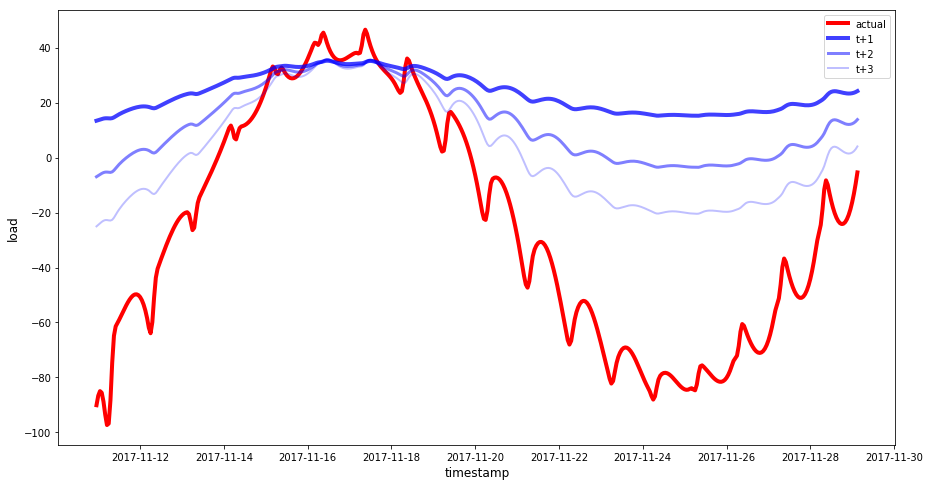

In [98]:
plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[ (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

# take input here

In [102]:
a = df.iloc[456:480  , :]
Actual = df.iloc[480:504,:]

In [103]:
new_df = pd.DataFrame()

In [104]:
columns = Paras[var_name] 

In [105]:
for key , value in enumerate(columns):
    new_df[value] = a[value]

In [106]:
new_df = new_df.dropna( how = 'any')

In [107]:
new_df

,Crs
Epoch_Time_of_Clock,
2017-11-21 00:00:00,-25.22663142380000067533
2017-11-21 01:00:00,-28.41827902140000006170
2017-11-21 02:00:00,-31.84350056099999903836
2017-11-21 03:00:00,-35.49633763730000168835
2017-11-21 04:00:00,-39.35827096570000094289
2017-11-21 05:00:00,-43.12188104129999999259
2017-11-21 06:00:00,-46.16784162479999764628
2017-11-21 07:00:00,-47.33511578249999729451
2017-11-21 08:00:00,-45.04067503520000315120


In [108]:
# creating index for output
import datetime
date = new_df.index.date[0]
date + datetime.timedelta(1)

datetime.date(2017, 11, 22)

In [109]:
import datetime
date = new_df.index + datetime.timedelta(days =1)

In [110]:
date

DatetimeIndex(['2017-11-22 00:00:00', '2017-11-22 01:00:00',
               '2017-11-22 02:00:00', '2017-11-22 03:00:00',
               '2017-11-22 04:00:00', '2017-11-22 05:00:00',
               '2017-11-22 06:00:00', '2017-11-22 07:00:00',
               '2017-11-22 08:00:00', '2017-11-22 09:00:00',
               '2017-11-22 10:00:00', '2017-11-22 11:00:00',
               '2017-11-22 12:00:00', '2017-11-22 13:00:00',
               '2017-11-22 14:00:00', '2017-11-22 15:00:00',
               '2017-11-22 16:00:00', '2017-11-22 17:00:00',
               '2017-11-22 18:00:00', '2017-11-22 19:00:00',
               '2017-11-22 20:00:00', '2017-11-22 21:00:00',
               '2017-11-22 22:00:00', '2017-11-22 23:00:00'],
              dtype='datetime64[ns]', name='Epoch_Time_of_Clock', freq='H')

In [111]:
new_df.index= date

In [112]:
new_df.columns

Index(['Crs'], dtype='object')

In [113]:
print(new_df)
print(new_df.columns)

                                         Crs
Epoch_Time_of_Clock                         
2017-11-22 00:00:00 -25.22663142380000067533
2017-11-22 01:00:00 -28.41827902140000006170
2017-11-22 02:00:00 -31.84350056099999903836
2017-11-22 03:00:00 -35.49633763730000168835
2017-11-22 04:00:00 -39.35827096570000094289
2017-11-22 05:00:00 -43.12188104129999999259
2017-11-22 06:00:00 -46.16784162479999764628
2017-11-22 07:00:00 -47.33511578249999729451
2017-11-22 08:00:00 -45.04067503520000315120
2017-11-22 09:00:00 -40.14312457850000015469
2017-11-22 10:00:00 -35.87404807800000128282
2017-11-22 11:00:00 -33.46396793449999762515
2017-11-22 12:00:00 -32.05489151780000156577
2017-11-22 13:00:00 -31.15036804289999849971
2017-11-22 14:00:00 -30.70715028929999945717
2017-11-22 15:00:00 -30.70169553929999750608
2017-11-22 16:00:00 -31.11046107510000169327
2017-11-22 17:00:00 -31.90990417900000153395
2017-11-22 18:00:00 -33.07648213299999895298
2017-11-22 19:00:00 -34.58665221959999769297
2017-11-22

In [114]:
freq = None
idx_tuples = []
drop_incomplete  = True
new_df[[var_name]] = X_scaler.transform(new_df)
new_new_df = new_df.copy()
tensor_structure={'X':(range(-T+1, 1), [var_name])}
for name, structure in tensor_structure.items():
        rng = structure[0]
        dataset_cols = structure[1]
        for col in dataset_cols:
        # do not shift non-sequential 'static' features
            if rng is None:
                new_df['context_'+col] = new_df[col]
                idx_tuples.append((name, col, 'static'))
            else:
                for t in rng:
                    sign = '+' if t > 0 else ''
                    shift = str(t) if t != 0 else ''
                    period = 't'+sign+shift
                    shifted_col = name+'_'+col+'_'+ period
                    new_new_df[shifted_col] = new_new_df[col].shift(t*-1, freq=freq)
                    idx_tuples.append((name, col, period))
        new_new_df = new_new_df.drop(new_df.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        print(new_df.head())
        new_new_df.columns = idx
        if drop_incomplete:
            new_new_df = new_new_df.dropna(how='any')
            
inputs = {}           
for name, structure in tensor_structure.items():
    rng = structure[0]
    cols = structure[1]
    tensor = new_new_df[name][cols].as_matrix()
    if rng is None:
        tensor = tensor.reshape(tensor.shape[0], len(cols))
    else:
        tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
        tensor = np.transpose(tensor, axes=[0, 2, 1])
    inputs[name] = tensor

                                        Crs
Epoch_Time_of_Clock                        
2017-11-22 00:00:00 -2.12741813136262569728
2017-11-22 01:00:00 -2.24011300272138669243
2017-11-22 02:00:00 -2.36105520858106299187
2017-11-22 03:00:00 -2.49003436176755288400
2017-11-22 04:00:00 -2.62639655913778247154


In [115]:
print(new_new_df)
print(inputs['X'])

tensor                                    X                          \
feature                                 Crs                           
time step                              t-23                    t-22   
Epoch_Time_of_Clock                                                   
2017-11-22 23:00:00 -2.12741813136262569728 -2.24011300272138669243   

tensor                                                               \
feature                                                               
time step                              t-21                    t-20   
Epoch_Time_of_Clock                                                   
2017-11-22 23:00:00 -2.36105520858106299187 -2.49003436176755288400   

tensor                                                               \
feature                                                               
time step                              t-19                    t-18   
Epoch_Time_of_Clock                                                   
2017

In [116]:
predictions = model.predict(inputs['X'])

In [117]:
predictions

array([[-0.5050419, -0.9880693, -1.4380947, -1.8454785, -2.2052848,
        -2.5162396, -2.7799807, -3.0002894, -3.182227 , -3.3313234,
        -3.4529636, -3.5520194, -3.632691 , -3.6984868, -3.7522793,
        -3.7963884, -3.8326774, -3.8626344, -3.8874512, -3.908079 ,
        -3.9252813, -3.9396727, -3.9517477, -3.961909 ]], dtype=float32)

In [118]:
print(predictions.shape)


(1, 24)


In [119]:
results = predictions[-1, :]

In [120]:
results

array([-0.5050419, -0.9880693, -1.4380947, -1.8454785, -2.2052848,
       -2.5162396, -2.7799807, -3.0002894, -3.182227 , -3.3313234,
       -3.4529636, -3.5520194, -3.632691 , -3.6984868, -3.7522793,
       -3.7963884, -3.8326774, -3.8626344, -3.8874512, -3.908079 ,
       -3.9252813, -3.9396727, -3.9517477, -3.961909 ], dtype=float32)

In [121]:
res_df = pd.DataFrame(results , columns = [var_name])
res_df

,Crs
0,-0.50504189729690551758
1,-0.98806929588317871094
2,-1.43809473514556884766
3,-1.84547853469848632812
4,-2.20528483390808105469
5,-2.51623964309692382812
6,-2.77998065948486328125
7,-3.00028944015502929688
8,-3.18222689628601074219
9,-3.33132338523864746094


In [122]:
res_df.index = date
res_df

,Crs
Epoch_Time_of_Clock,
2017-11-22 00:00:00,-0.50504189729690551758
2017-11-22 01:00:00,-0.98806929588317871094
2017-11-22 02:00:00,-1.43809473514556884766
2017-11-22 03:00:00,-1.84547853469848632812
2017-11-22 04:00:00,-2.20528483390808105469
2017-11-22 05:00:00,-2.51623964309692382812
2017-11-22 06:00:00,-2.77998065948486328125
2017-11-22 07:00:00,-3.00028944015502929688
2017-11-22 08:00:00,-3.18222689628601074219


In [123]:
res_df[var_name] = y_scalar.inverse_transform(res_df[[var_name]])    

# final generated output 

In [124]:
# final generated ouput
res_df['actual'] = Actual

In [125]:
res_df.to_csv('SA1_Crs.csv')

In [127]:
from sklearn.metrics import mean_absolute_error
a = mean_absolute_error(res_df['Crs'], res_df['actual'])
a

23.373943763777543